In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/Online Retail.csv')

In [ ]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [ ]:
data.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [ ]:
#Removing the negative values from Quantity and UnitPrice
#Quantity

data = data[data.Quantity > 0]

#UnitPrice

data = data[data.UnitPrice > 0]


In [ ]:
#InvoiceDate

data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['InvoiceYearMonth'] = data['InvoiceDate'].map(lambda date: 100*date.year + date.month)
data['Date'] = data['InvoiceDate'].dt.strftime('%Y-%m')

In [ ]:
#timebound

print(data["InvoiceDate"].min())
print(data["InvoiceDate"].max())

#The data is from 1 year transaction

2010-12-01 08:26:00
2011-12-09 12:50:00


In [ ]:
#Removing the Null values from the data
#CustomerID

data = data[pd.notnull(data['CustomerID'])]

#Description

data['Description'].fillna('No Description', inplace=True)

<ipython-input-119-0eb61d7d0ee1>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Description'].fillna('No Description', inplace=True)


In [ ]:
data.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0
InvoiceYearMonth,0
Date,0


In [ ]:
#Calculate the total price for each transaction

data['TotalPrice'] = data['Quantity'] * data['UnitPrice']

In [ ]:
most_recent_date = data['InvoiceDate'].max()
customer_data = data.groupby('CustomerID').agg({'InvoiceDate': lambda x: (most_recent_date - x.max()).days,
                                            'InvoiceNo': 'count',
                                            'TotalPrice': 'sum'})
customer_data.rename(columns={'InvoiceDate':'Recency', 'InvoiceNo':'Frequency', 'TotalPrice':'Monetary'}, inplace=True)
customer_data.head(5)

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12347.0,1,182,4310.00
12348.0,74,31,1797.24
12349.0,18,73,1757.55
12350.0,309,17,334.40


In [ ]:
customer_data.describe()

,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000
mean,91.536422,91.720609,2054.266460
std,100.014169,228.785094,8989.230441
min,0.000000,1.000000,3.750000
25%,17.000000,17.000000,307.415000
50%,50.000000,41.000000,674.485000
75%,141.000000,100.000000,1661.740000
max,373.000000,7847.000000,280206.020000


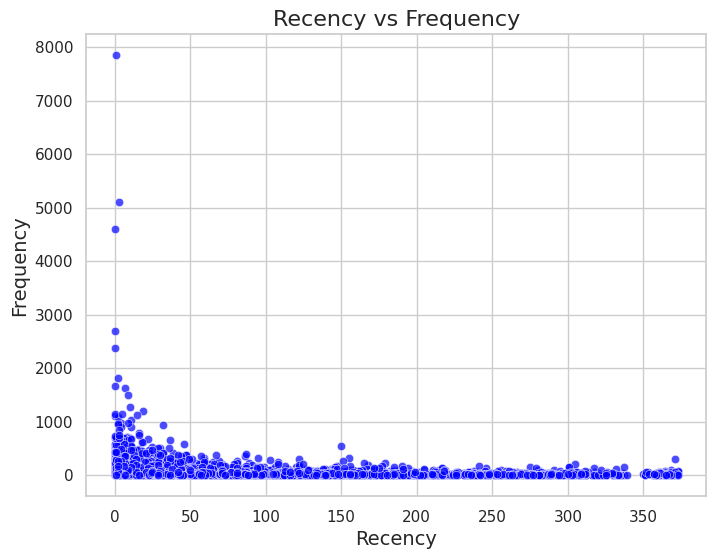

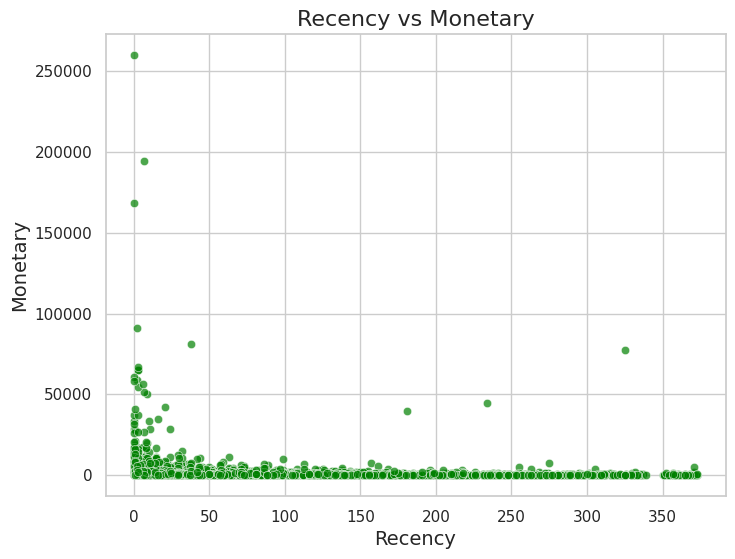

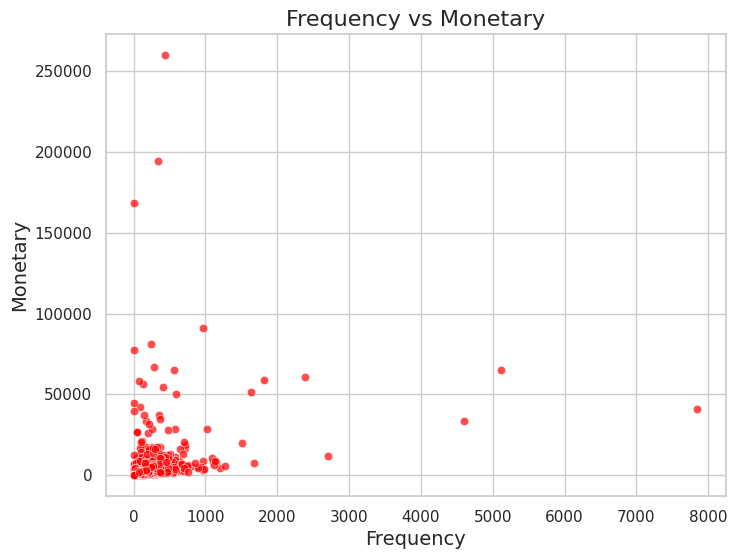

In [ ]:
# Setting the style for Seaborn
sns.set(style="whitegrid")

# Plot 1: Recency vs. Frequency
plt.figure(figsize=(8, 6))
sns.scatterplot(data=customer_data, x='Recency', y='Frequency', alpha=0.7, color='blue')
plt.title('Recency vs Frequency', fontsize=16)
plt.xlabel('Recency', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

# Plot 2: Recency vs. Monetary
plt.figure(figsize=(8, 6))
sns.scatterplot(data=customer_data, x='Recency', y='Monetary', alpha=0.7, color='green')
plt.title('Recency vs Monetary', fontsize=16)
plt.xlabel('Recency', fontsize=14)
plt.ylabel('Monetary', fontsize=14)
plt.show()

# Plot 3: Frequency vs. Monetary
plt.figure(figsize=(8, 6))
sns.scatterplot(data=customer_data, x='Frequency', y='Monetary', alpha=0.7, color='red')
plt.title('Frequency vs Monetary', fontsize=16)
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Monetary', fontsize=14)
plt.show()


In [ ]:
#Standardization

normal_data = StandardScaler().fit_transform(customer_data)
normal_data

#Ensures that all the variables are on the same scale, which is necessary for K-means clustering.

array([[ 2.34916460e+00, -4.10449826e-01,  1.00669064e+01],
       [-9.06424525e-01,  5.79114471e-02,  3.11636875e-01],
       [-9.16472639e-01,  2.06841746e+01,  4.25767546e+00],
       ...,
       [-8.46135837e-01, -3.59940277e-01, -2.25389800e-01],
       [-8.86328295e-01,  3.05634195e+00,  3.08070865e-02],
       [-4.94451826e-01, -9.36172002e-02, -3.62284108e-03]])

In [ ]:
#Determining the Optimal Number of Clusters (Elbow Method)
inertia = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normal_data)
    inertia.append(kmeans.inertia_)

Text(0, 0.5, 'Inertia')

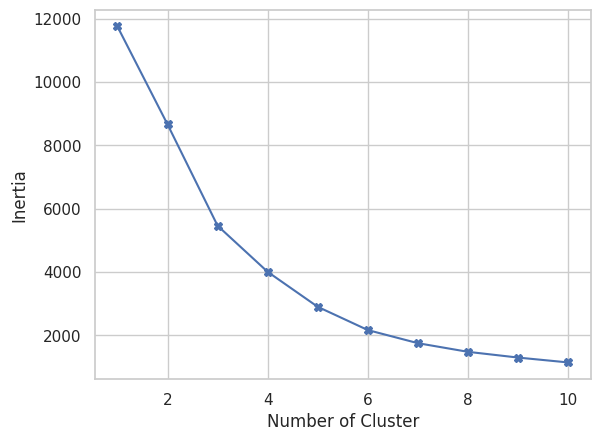

In [ ]:
#Plot the Elbow Curve

plt.plot(range(1,11), inertia, marker='X')
plt.xlabel('Number of Cluster')
plt.ylabel('Inertia')

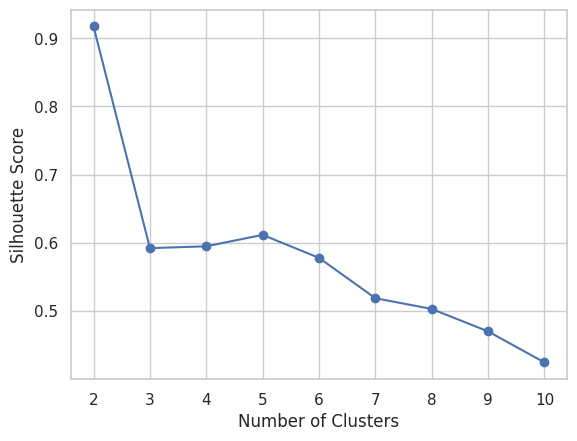

In [ ]:
#Silhouette Score

sil = []
for k in range(2,11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normal_data)
    sil.append(silhouette_score(normal_data, kmeans.labels_))

plt.plot(range(2,11), sil, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()

In [ ]:
#Final Customer Segmentation

final_kmeans = KMeans(n_clusters=3,random_state=42)
final_kmeans.fit(normal_data)

KMeans(n_clusters=3, random_state=42)

In [ ]:
print(davies_bouldin_score(normal_data, kmeans.labels_))

0.688954063558952


In [ ]:
final_data = pd.DataFrame(customer_data, columns=customer_data.columns, index=customer_data.index)
final_data['Cluster'] = final_kmeans.labels_ + 1
final_data.head(10)

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12346.0,325,1,77183.60,2
12747.0,1,103,4196.01,3
12748.0,0,4595,33719.73,2
12749.0,3,199,4090.88,3
12820.0,2,59,942.34,3
12821.0,213,6,92.72,1
12822.0,70,46,948.88,3
12823.0,74,5,1759.50,3
12824.0,59,25,397.12,3


In [ ]:
final_data.groupby('Cluster').agg({'Monetary':'mean',
                                 'Frequency':'mean',
                                 'Recency':'mean'})

,Monetary,Frequency,Recency
Cluster,,,
1,494.040286,27.699187,244.073171
2,88453.224000,1927.266667,26.066667
3,1881.361709,102.073263,40.047244


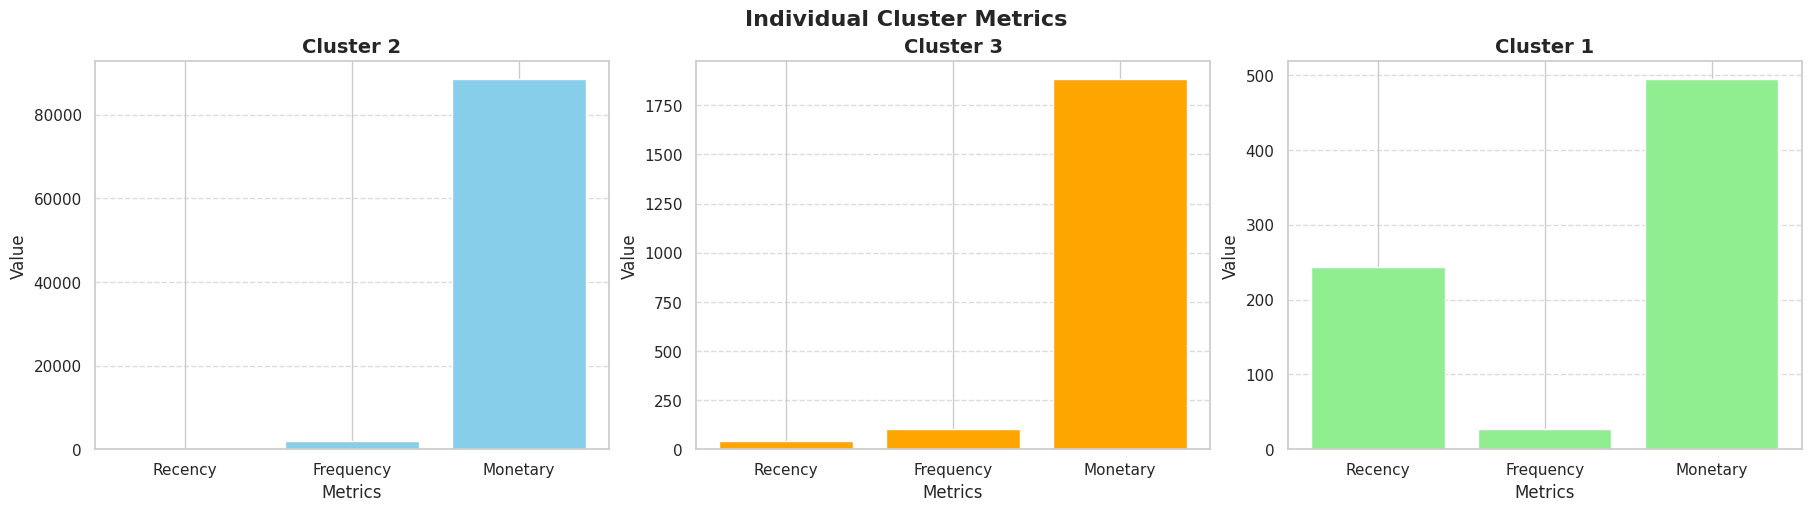

In [ ]:
# Plot each cluster individually
fig, axs = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)
colors = ['skyblue', 'orange', 'lightgreen']
metrics = ['Recency', 'Frequency', 'Monetary'] # Define metrics explicitly

# Iterate through unique clusters and plot their metrics
for i, cluster in enumerate(final_data["Cluster"].unique()):
    cluster_data = final_data[final_data["Cluster"] == cluster]
    cluster_means = cluster_data[['Recency', 'Frequency', 'Monetary']].mean()

    axs[i].bar(metrics, cluster_means, color=colors[i])
    axs[i].set_title(f"Cluster {cluster}", fontsize=14, weight='bold')
    axs[i].set_ylabel("Value", fontsize=12)
    axs[i].set_xlabel("Metrics", fontsize=12)
    axs[i].grid(axis="y", linestyle="--", alpha=0.7)

plt.suptitle("Individual Cluster Metrics", fontsize=16, weight='bold')
plt.show()